# Packages

In [71]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from numpy.linalg import norm
import numpy as np
import math

# Set Root and Import from HelpfulFunctions

In [72]:
import sys
root = '../../'
sys.path.append(root)
from HelpfulFunctions.batchCreation import createBatch
from HelpfulFunctions.metrics import meanAveragePrecision

# Load Features

In [73]:
X_train = np.load( root + "Features/train_features_vgg16_cifar10.npy" ) # Shape = (40000, 4096)
X_train_tensor = torch.tensor(X_train)
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" ) # Shape = (40000,)

X_test = np.load( root + "Features/test_features_vgg16_cifar10.npy" ) # Shape = (10000, 4096)
X_test_tensor = torch.tensor(X_test)
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" ) # Shape = (10000,)

# Setup Model

In [74]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 256),  # First fully connected layer
            nn.ReLU(),
            nn.Linear(256, 32),    # Second fully connected layer to reduce to 4000
            nn.ReLU()
        )

        # Initialize weights and biases from gaussian distribution
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Initialize weights based on paper
                nn.init.normal_(layer.bias, mean=0.0, std=0.01)    # Initialize biases based on paper

    def forward(self, x):
        return self.fc_layers(x)

In [75]:
model = CustomNN()

# Define Custom Loss Function

In [76]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self, eta = 0.001):
        super(CustomLoss, self).__init__()
        self.eta = eta

    def forward(self, outputs: torch.Tensor, targets):
        #S calculation
        targets = torch.tensor(targets)
        S = (targets[:, None] == targets).float() # Shape = (sample_size, sample_size)

        #U calculation
        U = outputs

        #Calculate Theta
        dot_product_matrix = torch.matmul(U, U.T)
        dot_product_matrix # (sample_size, sample_size) Shape
        Theta = 1/2 * dot_product_matrix
        

        #Calculate hash codes
        B = torch.sign(U) # Shape = (sample_size, hash_length)

        #Loss calculation -> Based on Equation 3 in paper
        loss1 = - torch.sum(S * Theta - torch.log(1 + torch.exp(Theta)))
        loss2 = self.eta * torch.sum(torch.linalg.norm((B - U), dim=1, ord=2).pow(2))

        loss = loss1 + loss2 

        print(str(float(loss1))[:6], "First part of loss function")
        print(str(float(loss2))[:6], "Second part of loss function")

        return loss.mean()

# Initialize CustomLoss And Optimizer

In [77]:
custom_loss = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learn Model Parameters

In [78]:
num_epochs = 1000

for epoch in range(num_epochs):
    #Create batch for current iteration
    X_batch_tensor, y_batch = createBatch(X_train_tensor, y_train, 100)

    # Zero gradients from the previous iteration
    optimizer.zero_grad()
    
    #Calculate outputs using model
    outputs = model(X_batch_tensor)

    # Forward pass
    loss = custom_loss(outputs, y_batch)
    
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Update parameters using optimizer
    optimizer.step()
    
    # Print loss for monitoring
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    

7258.1 First part of loss function
1.4531 Second part of loss function
Epoch [1/1000], Loss: 7259.56884765625
6947.6 First part of loss function
0.1529 Second part of loss function
Epoch [2/1000], Loss: 6947.84033203125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [3/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [4/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [5/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [6/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [7/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [8/1000], Loss: 6931.47314453125
6931.4 First part of loss function
0.0 Second part of loss function
Epoch [9/1000], Loss: 6931.47314453125
6931.4 First part of loss funct

# Create Hashcodes

In [9]:
hash_train = torch.sign(model(X_train_tensor))
hash_test = torch.sign(model(X_test_tensor))

In [10]:
torch.sum(hash_train)

tensor(0., grad_fn=<SumBackward0>)

# Evaluation

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

c:\Users\Test\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


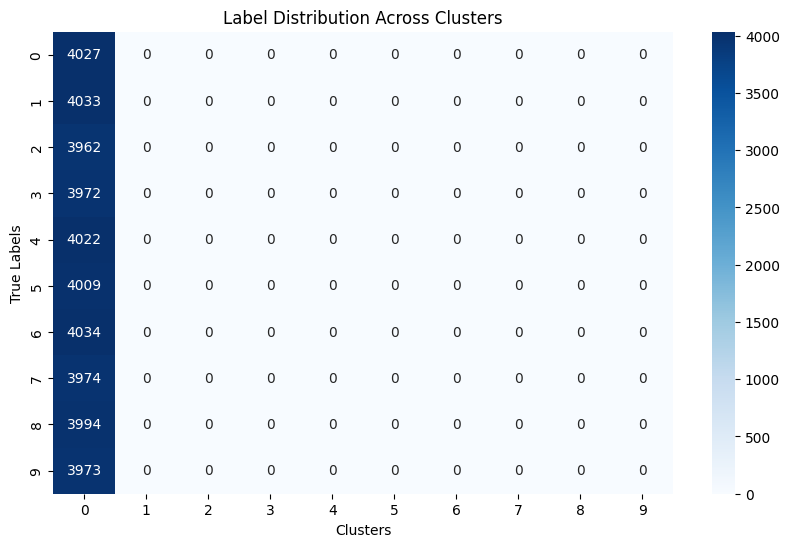

In [12]:
easyHeatmap(hash_train.detach().numpy(), y_train)

c:\Users\Test\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


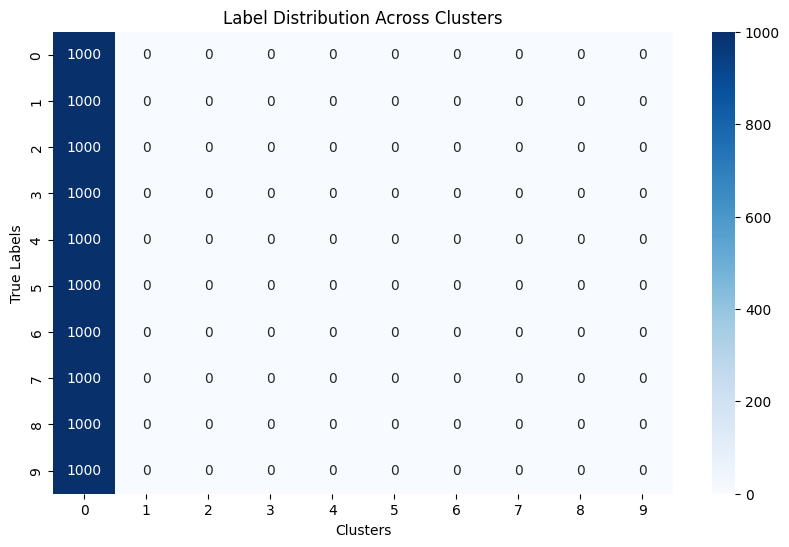

In [15]:
easyHeatmap(hash_test.detach().numpy(), y_test)